In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df_red = pd.read_csv("../dataset/winequality-red.csv", sep=';',index_col=False)
df_red['type'] = 1
df_white = pd.read_csv("../dataset/winequality-white.csv", sep=';',index_col=False)
df_white['type'] = 0
df_wine = pd.concat([df_red, df_white], ignore_index=True)
X = df_wine.drop("type", axis=1)
y = df_wine["type"]

In [10]:
#misturar o df para fazer df training e test aleatorios
idx = np.arange(len(df_wine))
np.random.seed(42)
np.random.shuffle(idx)
# 80% train, 20% test
split_point = int(0.8 * len(df_wine))

train_idx = idx[:split_point]
test_idx = idx[split_point:]

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]


In [11]:
scaler = (X_train.mean(), X_train.std())

X_train_sant = (X_train- scaler[0]) / scaler[1]
X_test_sant = (X_test - scaler[0]) / scaler[1]

In [12]:
X_train_scaled  = np.asarray(X_train_sant, dtype=float)
y_train = np.asarray(y_train, dtype=float)

X_test_scaled = np.asarray(X_test_sant, dtype=float)
y_test = np.asarray(y_test, dtype=float)

In [13]:
class QDAclassifier(object):
  
    def __init__(self):
        self.classes_ = None
        self.means_ = None
        self.covariances_ = None
        self.priors_ = None
        
    def _compute_class_statistics(self, X, y):
    
        n_features = X.shape[1]
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        self.means_ = np.zeros((n_classes, n_features))
        self.covariances_ = np.zeros((n_classes, n_features, n_features))
        self.priors_ = np.zeros(n_classes)
        
    
        for idx, class_label in enumerate(self.classes_):
         
            class_mask = (y == class_label)
            X_class = X[class_mask]

            self.means_[idx] = np.mean(X_class, axis=0)
   
            self.covariances_[idx] = np.cov(X_class.T)

            self.covariances_[idx] += np.eye(n_features) * 1e-6
            

            self.priors_[idx] = np.sum(class_mask) / len(y)
    
    def _compute_quadratic_discriminant(self, X, class_idx):
      
        mean = self.means_[class_idx]
        cov = self.covariances_[class_idx]
        prior = self.priors_[class_idx]
        
        # calcular inversa e determinante da matriz de covariancia
        cov_inv = np.linalg.inv(cov)
        cov_det = np.linalg.det(cov)
        

        X_centered = X - mean

        quad_form = np.einsum('ij,ij->i', X_centered @ cov_inv, X_centered)
        
        # discriminante
        # -0.5 * log|Σ| - 0.5 * (x - μ)^T * Σ^(-1) * (x - μ) + log(π)
        discriminant = -0.5 * np.log(cov_det) - 0.5 * quad_form + np.log(prior)
        
        return discriminant
    
    def fit(self, X, y):

        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        
        self._compute_class_statistics(X, y)
    
    def predict(self, X):
    
        X = np.asarray(X, dtype=float)
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        
        # discriminante pra cada classe
        discriminants = np.zeros((n_samples, n_classes))
        
        for class_idx in range(n_classes):
            discriminants[:, class_idx] = self._compute_quadratic_discriminant(X, class_idx)
        
        predicted_class_indices = np.argmax(discriminants, axis=1)
        predictions = self.classes_[predicted_class_indices]
        
        return predictions
    
    def predict_proba(self, X):
       
        X = np.asarray(X, dtype=float)
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
      
        discriminants = np.zeros((n_samples, n_classes))
        
        for class_idx in range(n_classes):
            discriminants[:, class_idx] = self._compute_quadratic_discriminant(X, class_idx)
        
        # discriminante para softmax
        discriminants_max = np.max(discriminants, axis=1, keepdims=True)
        exp_discriminants = np.exp(discriminants - discriminants_max)
        probabilities = exp_discriminants / np.sum(exp_discriminants, axis=1, keepdims=True)
        
        return probabilities


QDA Accuracy:  0.9869230769230769

QDA model and metrics saved successfully!


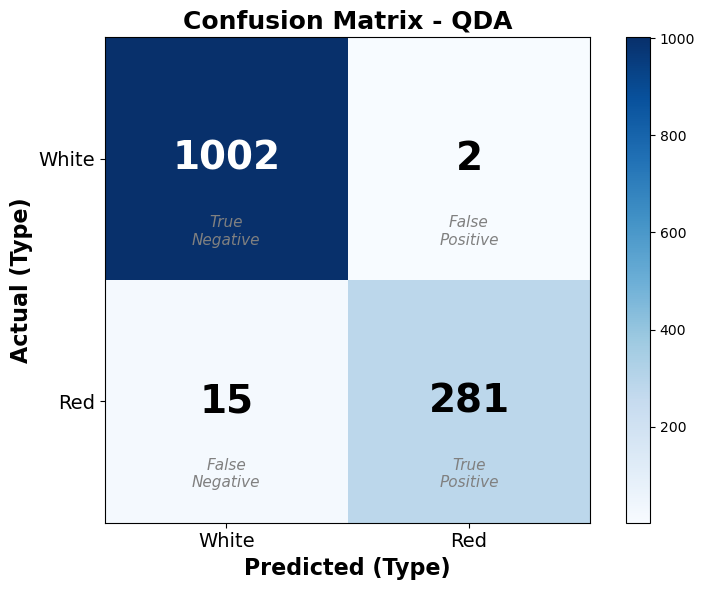

In [14]:
# QDA classifier
qda = QDAclassifier()
qda.fit(X_train_scaled, y_train)

# teste set
predictions = qda.predict(X_test_scaled)


def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

def confusion_matrix(y_true, y_pred, class_names=['White', 'Red']):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    TN = np.sum((y_true == 0) & (y_pred == 0))
    FN = np.sum((y_true == 0) & (y_pred == 1))
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 1) & (y_pred == 0))
    
    matrix = np.array([[TN, FP], [FN, TP]])

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar(im, ax=ax)
    

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(class_names, fontsize=14)
    ax.set_yticklabels(class_names, fontsize=14)
    
    ax.set_xlabel('Predicted (Type)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Actual (Type)', fontsize=16, fontweight='bold')
    ax.set_title('Confusion Matrix - QDA', fontsize=18, fontweight='bold')

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, matrix[i, j],
                          ha="center", va="center", 
                          color="white" if matrix[i, j] > matrix.max()/2 else "black",
                          fontsize=28, fontweight='bold')

    labels = [['True\nNegative', 'False\nPositive'],
              ['False\nNegative', 'True\nPositive']]
    
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i+0.3, labels[i][j],
                          ha="center", va="center", color="gray",
                          fontsize=11, style='italic')
    
    plt.tight_layout()
    return

print("QDA Accuracy: ", accuracy(y_test, predictions))
confusion_matrix(y_test, predictions)

# salvando modelo e metricas
import pickle
import os


os.makedirs('models', exist_ok=True)

# salvando QDA
with open('models/qda_model.pkl', 'wb') as f:
    pickle.dump(qda, f)


TN = np.sum((y_test == 0) & (predictions == 0))
FP = np.sum((y_test == 0) & (predictions == 1))
FN = np.sum((y_test == 1) & (predictions == 0))
TP = np.sum((y_test == 1) & (predictions == 1))

acc = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

qda_metrics = {
    'accuracy': acc,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'TN': TN,
    'FP': FP,
    'FN': FN,
    'TP': TP,
    'predictions': predictions
}

with open('models/qda_metrics.pkl', 'wb') as f:
    pickle.dump(qda_metrics, f)

np.save('models/qda_y_test.npy', y_test)

print("\nQDA model and metrics saved successfully!")


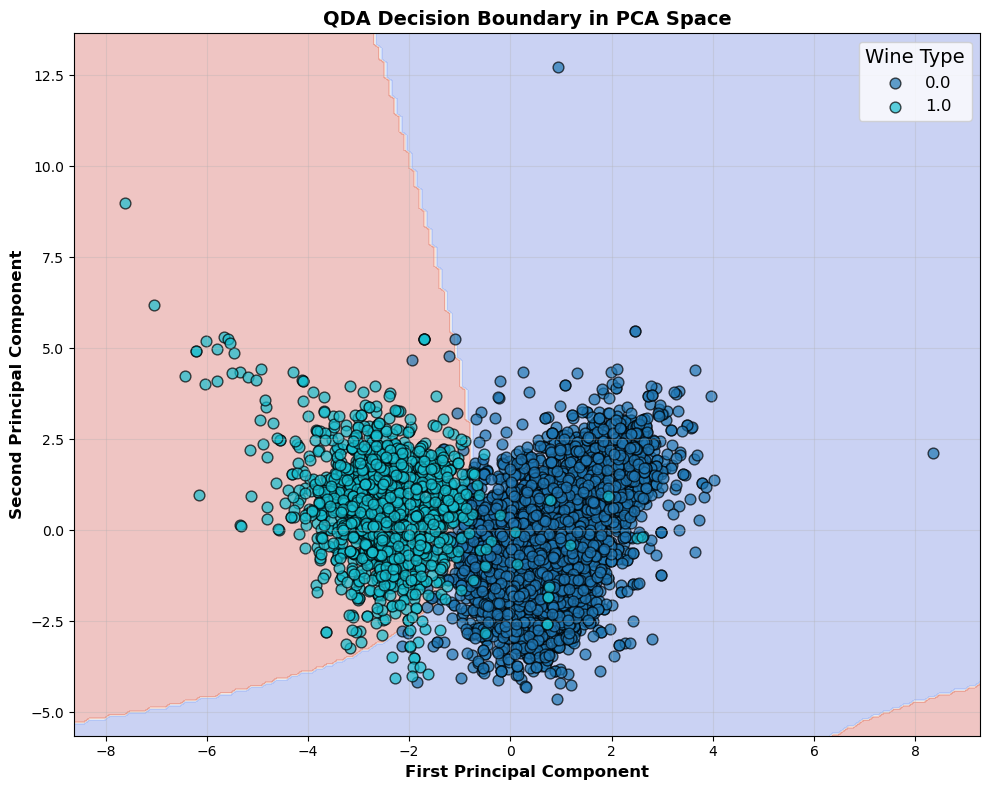

In [15]:
# Gráfico da Fronteira de Decisão QDA
import matplotlib.cm as cm
from sklearn.decomposition import PCA

# Usar PCA para projeção 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Combinar dados de treino e teste para visualização
X_all_pca = np.vstack([X_train_pca, X_test_pca])
y_all = np.concatenate([y_train, y_test])

# Criar grade para fronteira de decisão
x_min, x_max = X_all_pca[:, 0].min() - 1, X_all_pca[:, 0].max() + 1
y_min, y_max = X_all_pca[:, 1].min() - 1, X_all_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Prever classes na grade usando QDA
grid_points = np.c_[xx.ravel(), yy.ravel()]
# Inverter PCA para voltar ao espaço original
grid_points_original = pca.inverse_transform(grid_points)
Z = qda.predict(grid_points_original)
Z = Z.reshape(xx.shape)

# Plotar
plt.figure(figsize=(10, 8))

# Plotar regiões de decisão
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Plotar pontos de dados
classes = np.unique(y_all)
colors = cm.tab10(np.linspace(0, 1, len(classes)))

for i, c in enumerate(classes):
    mask = y_all == c
    plt.scatter(X_all_pca[mask, 0], X_all_pca[mask, 1],
                s=60, color=colors[i], edgecolors="black",
                alpha=0.7, label=str(c))

plt.xlabel("First Principal Component", fontsize=12, fontweight="bold")
plt.ylabel("Second Principal Component", fontsize=12, fontweight="bold")
plt.title("QDA Decision Boundary in PCA Space", fontsize=14, fontweight="bold")
plt.legend(title="Wine Type", fontsize=12, title_fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
